# Random Forest

## Imports

In [35]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import warnings
from sklearn.utils import resample
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

In [36]:
TRAIN_CSV = '../data/activity_train.csv'   # path to train CSV
TEST_CSV  = '../data/activity_test.csv'    # path to test CSV

label_map = {
    1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS',
    4:'SITTING', 5:'STANDING', 6:'LAYING',
    7:'STAND_TO_SIT', 8:'SIT_TO_STAND', 9:'SIT_TO_LIE',
    10:'LIE_TO_SIT', 11:'STAND_TO_LIE', 12:'LIE_TO_STAND'
}

## Loading dataset

In [37]:
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)
print('train shape:', df_train.shape)
print('test  shape:', df_test.shape)

X_train = df_train.drop(columns=['activity'])
y_train = df_train['activity'].copy()
X_test = df_test.drop(columns=['activity'])
y_test = df_test['activity'].copy()

train_cols = list(X_train.columns)
test_cols = list(X_test.columns)
X_test = X_test[train_cols]

train shape: (7767, 562)
test  shape: (3162, 562)


## Splitting by time / frequency

In [38]:
def split_time_freq_columns(cols):
    time_cols = [c for c in cols if re.match(r'^[tT]', c)]
    freq_cols = [c for c in cols if re.match(r'^[fF]', c) or 'freq' in c.lower() or 'fft' in c.lower()]
    # remove overlaps and keep others separate
    freq_cols = [c for c in freq_cols if c not in time_cols]
    other_cols = [c for c in cols if c not in time_cols + freq_cols]
    return time_cols, freq_cols, other_cols

time_cols, freq_cols, other_cols = split_time_freq_columns(X_train.columns.tolist())
print('time:', len(time_cols), 'freq:', len(freq_cols), 'other:', len(other_cols))

time: 272 freq: 289 other: 0


In [39]:
def ensure_and_order(X_src, desired_cols):
    X = X_src.copy()
    for c in desired_cols:
        if c not in X.columns:
            X[c] = 0.0
    return X[desired_cols]

X_train_time = ensure_and_order(X_train, time_cols)
X_test_time  = ensure_and_order(X_test, time_cols)

X_train_freq = ensure_and_order(X_train, freq_cols)
X_test_freq  = ensure_and_order(X_test, freq_cols)

combined_cols = list(dict.fromkeys(time_cols + freq_cols))  # preserve order, unique
X_train_comb = ensure_and_order(X_train, combined_cols)
X_test_comb  = ensure_and_order(X_test, combined_cols)


## Training and testing

In [40]:
def upsample_minority(X, y, target=None):
    df = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True).rename('activity')], axis=1)
    counts = df['activity'].value_counts()
    if target is None:
        target = int(counts.median())
    parts = []
    for cls, grp in df.groupby('activity'):
        if len(grp) < target:
            grp = resample(grp, replace=True, n_samples=target, random_state=RANDOM_STATE)
        parts.append(grp)
    up = pd.concat(parts).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    return up.drop(columns='activity'), up['activity']

In [41]:
X_up, y_up = upsample_minority(X_train_time, y_train, target=200)

In [42]:
def train_and_eval(name, X_tr, X_te, y_tr, y_te, n_estimators=200):

    labels = np.unique(y_te)
    label_names = [label_map.get(int(l), str(l)) for l in labels]

    cv = StratifiedKFold(n_splits=4, shuffle=True,random_state=RANDOM_STATE)

    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced', min_samples_leaf=32)

    clf.fit(X_tr, y_tr)
    y_pred = clf.predict(X_te)

    print(f'=== {name} ===')
    print('Train F1 macro:', f1_score(y_tr, clf.predict(X_tr), average='macro'))
    print('Test  F1 macro:', f1_score(y_te,  clf.predict(X_te),  average='macro'))

    print(classification_report(y_te, y_pred, digits=4))
    cm = confusion_matrix(y_te, y_pred)

    cv_score = cross_val_score(clf, X_tr, y_tr, scoring='f1_macro', cv=cv, n_jobs=-1)
    print('CV f1_macro mean/std:', cv_score.mean(), cv_score.std())

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()
    return clf

=== Time features ===
Train F1 macro: 0.9059784259545776
Test  F1 macro: 0.7895420704177631
              precision    recall  f1-score   support

           1     0.8433    0.9657    0.9004       496
           2     0.8846    0.8790    0.8818       471
           3     0.9543    0.7952    0.8675       420
           4     0.8409    0.8425    0.8417       508
           5     0.8647    0.8507    0.8577       556
           6     1.0000    0.9963    0.9982       545
           7     0.5676    0.9130    0.7000        23
           8     0.7143    1.0000    0.8333        10
           9     0.6585    0.8438    0.7397        32
          10     0.5833    0.5600    0.5714        25
          11     0.8333    0.6122    0.7059        49
          12     0.6000    0.5556    0.5769        27

    accuracy                         0.8817      3162
   macro avg     0.7787    0.8178    0.7895      3162
weighted avg     0.8860    0.8817    0.8815      3162

CV f1_macro mean/std: 0.8105514506058227 

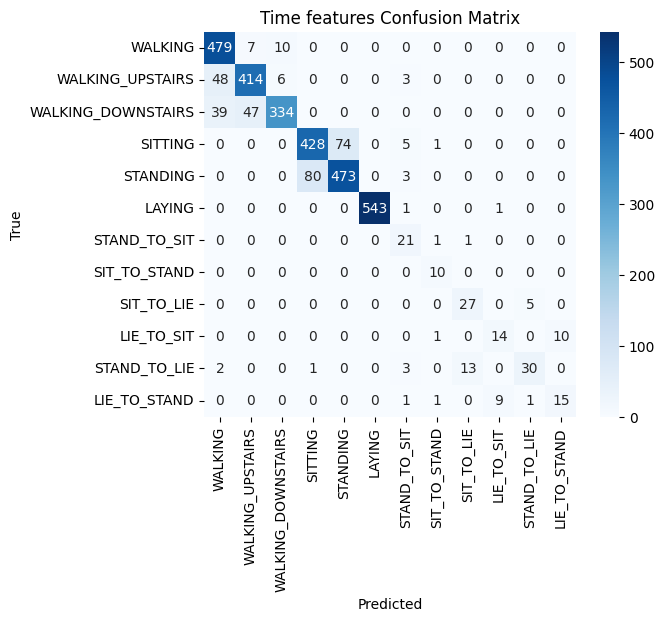

=== Frequency features ===
Train F1 macro: 0.7871686596158853
Test  F1 macro: 0.6590100476877089
              precision    recall  f1-score   support

           1     0.9041    0.9698    0.9358       496
           2     0.8768    0.9214    0.8986       471
           3     0.9335    0.8024    0.8630       420
           4     0.7898    0.7028    0.7438       508
           5     0.7752    0.8867    0.8272       556
           6     0.8693    0.8055    0.8362       545
           7     0.3784    0.6087    0.4667        23
           8     0.3810    0.8000    0.5161        10
           9     0.5455    0.1875    0.2791        32
          10     0.4412    0.6000    0.5085        25
          11     0.5741    0.6327    0.6019        49
          12     0.4583    0.4074    0.4314        27

    accuracy                         0.8305      3162
   macro avg     0.6606    0.6937    0.6590      3162
weighted avg     0.8352    0.8305    0.8292      3162

CV f1_macro mean/std: 0.628191304848

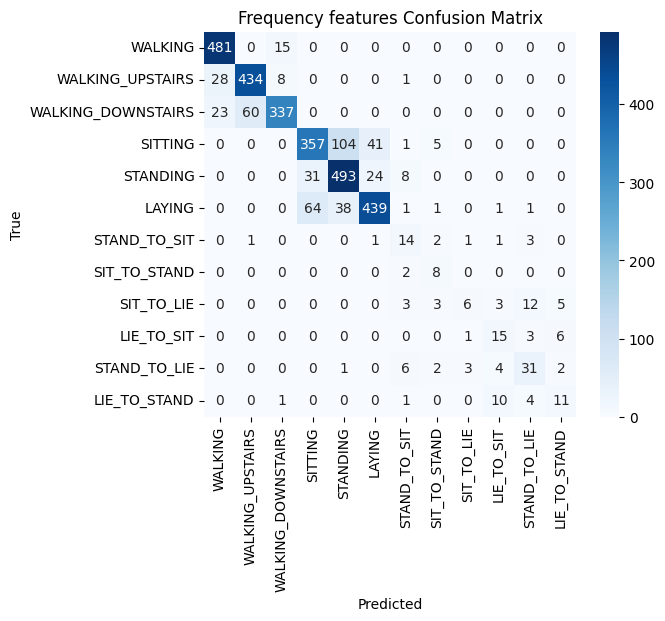

=== Time+Freq combined ===
Train F1 macro: 0.9048301515418605
Test  F1 macro: 0.7957756387208357
              precision    recall  f1-score   support

           1     0.8620    0.9698    0.9127       496
           2     0.8924    0.8981    0.8952       471
           3     0.9465    0.8000    0.8671       420
           4     0.9175    0.8760    0.8963       508
           5     0.8998    0.9209    0.9102       556
           6     1.0000    0.9945    0.9972       545
           7     0.5385    0.9130    0.6774        23
           8     0.7143    1.0000    0.8333        10
           9     0.6279    0.8438    0.7200        32
          10     0.6250    0.6000    0.6122        25
          11     0.7941    0.5510    0.6506        49
          12     0.6000    0.5556    0.5769        27

    accuracy                         0.9026      3162
   macro avg     0.7848    0.8269    0.7958      3162
weighted avg     0.9068    0.9026    0.9023      3162

CV f1_macro mean/std: 0.821302008886

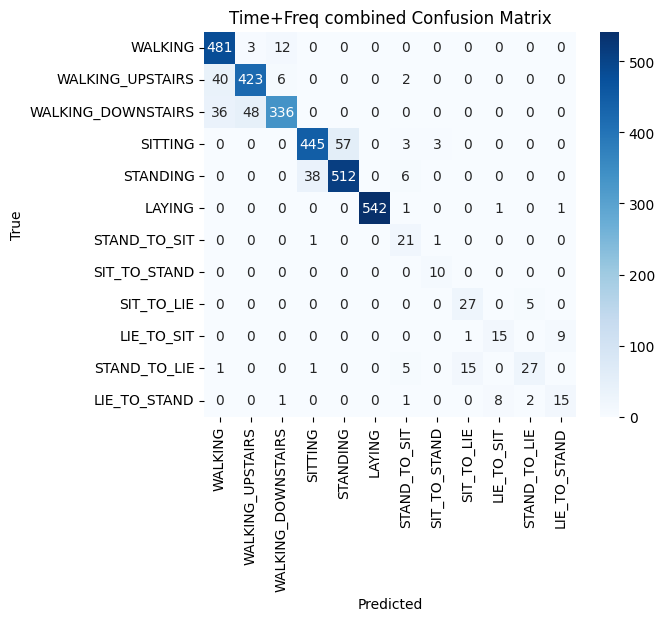

=== All features (baseline) ===
Train F1 macro: 0.9015533433183077
Test  F1 macro: 0.7835689773081409
              precision    recall  f1-score   support

           1     0.8842    0.9698    0.9250       496
           2     0.8988    0.9236    0.9110       471
           3     0.9468    0.8048    0.8700       420
           4     0.9295    0.8819    0.9051       508
           5     0.9037    0.9281    0.9157       556
           6     1.0000    0.9945    0.9972       545
           7     0.5000    0.8261    0.6230        23
           8     0.6250    1.0000    0.7692        10
           9     0.5909    0.8125    0.6842        32
          10     0.6087    0.5600    0.5833        25
          11     0.7647    0.5306    0.6265        49
          12     0.5926    0.5926    0.5926        27

    accuracy                         0.9080      3162
   macro avg     0.7704    0.8187    0.7836      3162
weighted avg     0.9122    0.9080    0.9079      3162

CV f1_macro mean/std: 0.8233692

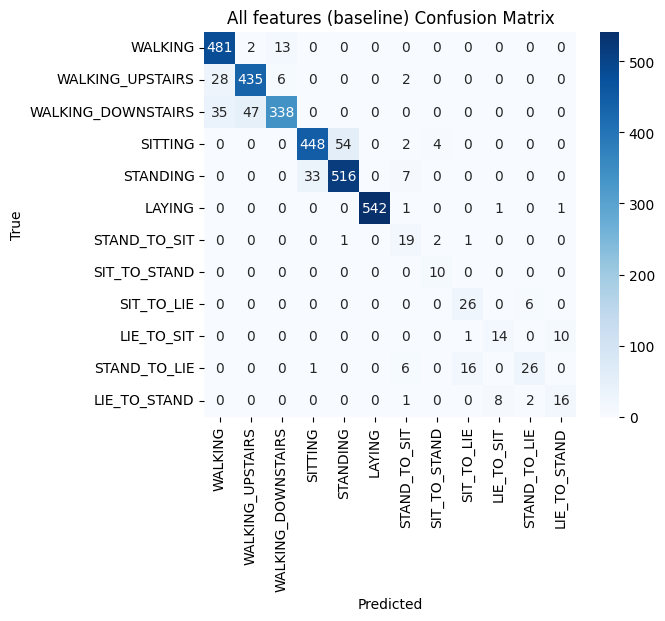

=== Resampled rows (time) ===
Train F1 macro: 0.9615137902472704
Test  F1 macro: 0.8098037673006018
              precision    recall  f1-score   support

           1     0.8410    0.9597    0.8964       496
           2     0.8771    0.8790    0.8780       471
           3     0.9542    0.7929    0.8661       420
           4     0.8463    0.8346    0.8404       508
           5     0.8590    0.8543    0.8566       556
           6     1.0000    0.9945    0.9972       545
           7     0.5676    0.9130    0.7000        23
           8     0.7692    1.0000    0.8696        10
           9     0.6667    0.9375    0.7792        32
          10     0.6552    0.7600    0.7037        25
          11     0.9118    0.6327    0.7470        49
          12     0.6667    0.5185    0.5833        27

    accuracy                         0.8820      3162
   macro avg     0.8012    0.8397    0.8098      3162
weighted avg     0.8870    0.8820    0.8818      3162

CV f1_macro mean/std: 0.930807338

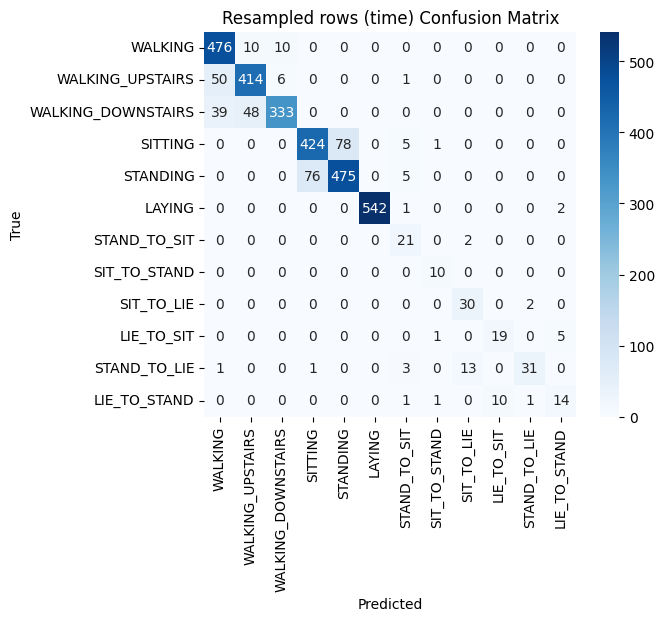

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",32
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metri

In [43]:
train_and_eval('Time features', X_train_time, X_test_time, y_train, y_test)
train_and_eval('Frequency features', X_train_freq, X_test_freq, y_train, y_test)
train_and_eval('Time+Freq combined', X_train_comb, X_test_comb, y_train, y_test)
train_and_eval('All features (baseline)', X_train, X_test, y_train, y_test)
train_and_eval('Resampled rows (time)', X_up, X_test_time, y_up, y_test)